# MNIST


In this project we will be using The MNISt dataset, which is a set of 70,000 small images of digits handwritten by high  school  students  and  employees  of  the  US  Cen‐sus Bureau. Each image is labeled with the digit it represents. This set has been stud‐ied  so  much  that  it  is  often  called  the  “hello  world”  of  Machine  Learning.
</br>
Scikit-Learn provides many helper functions to download popular datasets. MNIST isone of them. The following code fetches the MNIST dataset.

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, includ‐ing the following:
- A DESCR key describing the dataset
- A  data  key  containing  an  array  with  one  row  per  instance  and  one  column  perfeature
- A target key containing an array with the labels

In [66]:
X, y = mnist["data"], mnist["target"]

# this is different from the book (due to version mismatch of sklearn)
# The dataframe has to be changed to numpy array for further calculation
X = X.to_numpy() 
y = y.to_numpy()
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


There are 70,000 images, and each image has 784 features. This is because each imageis  28  ×  28  pixels,  and  each  feature  simply  represents  one  pixel’s  intensity,  from  0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All we need to do  is  grab  an  instance’s  feature  vector,  reshape  it  to  a  28  ×  28  array,  and  display  it using Matplotlib’s *imshow()* function.

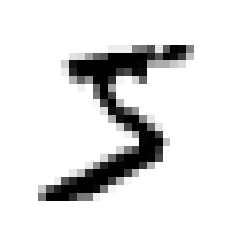

5


In [67]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(y[0])

The y label is string, lets change it to integer.

In [68]:
y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000images) and a test set (the last 10,000 images).
</br>
The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

In [69]:

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s  simplify  the  problem  for  now  and  only  try  to  identify  one  digit for  example, the  number  5.  This  “5-detector”  will  be  an  example  of  a  binary  classifier,  capable  of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task

In [70]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient  Descent  (SGD)  classifier,  using  Scikit-Learn’s  SGDClassifier  class.  This  classifier has  the  advantage  of  being  capable  of  handling  very  large  datasets  efficiently.  This  is in  part  because  SGD  deals  with  training  instances  independently,  one  at  a  time (which also makes SGD well suited for online learning), as we will see later. Let’s create an SGDClassifier and train it on the whole training set.

In [71]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5.

In [72]:
sgd_clf.predict([some_digit])

array([ True])

The prediction was indeed right as we have used *some_digit* which is variable with value 5.

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will  spend  a  large  part  of  this  chapter  on  this  topic.

### Measuring Accuracy Using Cross-Validation

Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, we can implement cross-validation ourself. The   following   code   does   roughly   the   same   thing   as   Scikit-Learns *cross_val_score()* function, and it prints the same result.
</br>
The  *StratifiedKFold*  class  performs  stratified  sampling  (as  explained  in  Chapter  2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions  on  the  test  fold.  Then  it  counts  the  number  of  correct  predictions  and outputs the ratio of correct predictions.

In [74]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred)) 
    

0.9669
0.91625
0.96785


Let’s  use  the  *cross_val_score()* function  to  evaluate  our  *SGDClassifier*  model, using K-fold cross-validation with three folds.

In [75]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Lets looka at a classifier that just classifies every single image in the "not-5" class.

In [77]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's find the model's accuracy.

In [78]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s  right,  it  has  over  90%  accuracy!  This  is  simply  because  only  about  10%  of  the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus. This demonstrates why accuracy is generally not the preferred performance measurefor  classifiers,  especially  when  you  are  dealing  with  skewed  datasets  (i.e.,  when  someclasses are much more frequent than others)